In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt

## Preparação de dados para criação de um dataset

In [2]:
class MyDataset (torch.utils.data.Dataset):
    """
    Esse dataset recebe uma lista de path de imagens, uma lista de labels correspondentes e (opcional) transformações pata aplicar nas imagens
    quando elas forem carregadas
    """

    def __init__(self, imgs_path, labels, my_transform=None):
        """
        imgs_path: list ou tuple
            Uma lista ou tupla com os paths para todas as imagens
        labels: lista ou tuple
            Uma lista ou tupla com o label de todas as imagens. Obviamente, precisa dar match com o os paths
        my_transform: None ou torchvision.transforms
            Uma sequência de transformadores para aplicar nos dados. Se for None, ele apenas transforma em tensor
        """

        super().__init__()
        self.imgs_path = imgs_path
        self.labels = labels
        
        # se my_transform for None, precisamos garantir que a imagem PIL seja transformada em Tensor para nao 
        # obtermos um erro quando usarmos o dataloader (ver aulas passadas)        
        if my_transform is not None:
            self.transform = my_transform
        else:
            self.transform = transforms.ToTensor()


    def __len__(self):     
        """
        Sobrecarga do método len para obtermos o tamanho do dataset. Não é obrigatório implementar
        """
        return len(self.imgs_path)


    def __getitem__(self, item):        
        """
        Esse método obtém uma imagem e um label cada vez que iteramos no Dataset. Ele também aplica a transformação
        na imagem. É obrigatório sua implementação
        
        item: int 
            Um indice no intervalo [0, ..., len(img_paths)-1]
        
        return: tuple 
             Uma tupla com a imagem, label e ID da imagem correspondentes ao item
        """

        # Aqui usamos PIL para carregar as imagens
        image = Image.open(self.imgs_path[item]).convert("RGB")

        # Aplicando as transformações
        image = self.transform(image)

        # Obtendo o ID da imagem
        img_id = self.imgs_path[item].split('/')[-1].split('.')[0]

        if self.labels is None:
            labels = []
        else:
            labels = self.labels[item]

        return image, labels, img_id

In [ ]:
from zipfile import ZipFile 
  
with ZipFile("archive.zip", 'r') as zObject: 
    zObject.extractall(path="") 

In [3]:
data_path = "Data"

labels_name = glob(os.path.join(data_path, "*"))
labels_name = [l.split(os.path.sep)[-1] for l in labels_name]
labels_name

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

Os dados apresentam 4 classes, sendo 1 saudável e 3 de tumores

In [4]:
def get_paths_and_labels(path, lab_names):
    imgs_path, labels = list(), list()
    lab_cnt = 0
    for lab in lab_names:    
        paths_aux = glob(os.path.join(path, lab, "*.jpg"))
        
        # Atualizando os labels e imgs_paths
        labels += [lab_cnt] * len(paths_aux)
        imgs_path += paths_aux
        
        lab_cnt += 1
        
    return imgs_path, labels

In [5]:
imgs_paths, labels = get_paths_and_labels(data_path, labels_name)

### Fazendo separação de treino (70%), teste (15%) e validação (15%)

In [6]:
from sklearn.model_selection import train_test_split
train_imgs_paths, to_valid_test_imgs_paths, train_labels, to_valid_test_labels = train_test_split(imgs_paths, labels, test_size=0.3, random_state=10)
valid_imgs_paths, test_imgs_paths, valid_labels, test_labels = train_test_split(to_valid_test_imgs_paths, to_valid_test_labels, test_size=0.5, random_state=10)
len(train_imgs_paths), len(test_imgs_paths), len(valid_imgs_paths)

(2167, 465, 464)

### Transformaçoes e augmentation

In [7]:
from imgaug import augmenters as iaa
import numpy as np
np.bool = np.bool_

Como há imagens em diferentes tipos de orientações no dataset, foram feitas alguams transformações para um treinamento mais homegêneo

In [8]:
my_aug = iaa.Sequential([
            iaa.Sometimes(0.25, iaa.Affine(scale={"x": (1.0, 1.5), "y": (1.0, 1.5)})),
            iaa.Resize((255, 255)),
            iaa.Fliplr(0.3),
            iaa.Flipud(0.2),
            iaa.Sometimes(0.25, iaa.Affine(rotate=(-180, 180), mode='symmetric')),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 2.0))),

            # noise
            iaa.Sometimes(0.1,
                          iaa.OneOf([
                              iaa.Dropout(p=(0, 0.05)),
                              iaa.CoarseDropout(0.02, size_percent=0.25)
                          ])),

            # brightness
            iaa.Sometimes(0.25,
                          iaa.OneOf([
                              iaa.Add((-15, 15)), 
                              iaa.AddToHueAndSaturation(value=(-10, 10))
                          ])),

        ])

my_trans = transforms.Compose([
                np.array,
                my_aug.augment_image,
                np.copy,
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
my_trans_eval = transforms.Compose([   
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

In [9]:
train_dataset = MyDataset(train_imgs_paths, train_labels, my_transform=my_trans)
test_dataset = MyDataset(test_imgs_paths, test_labels, my_transform=my_trans_eval)
val_dataset = MyDataset(valid_imgs_paths, valid_labels, my_transform=my_trans_eval)

In [10]:
batch_size = 30
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

### Primeiro modelo

In [11]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=7, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=4))
        self.fc = nn.Linear(784, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)        
        out = self.layer2(out)

        out = out.reshape(out.size(0), -1)        
        out = self.fc(out)
        return out

In [12]:
model = ConvNet()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=784, out_features=4, bias=True)
)

In [13]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

In [14]:
def eval_loss(data_loader):    
    with torch.no_grad():
        loss, cnt = 0, 0
        for images, labels, img_id in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss += loss_func(outputs, labels).item()
            cnt += 1
    return loss/cnt  

In [15]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [16]:
num_epochs = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model.to(device)

best_loss = np.inf

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    loss_epoch, cnt = 0, 0
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):  
        
        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Fazendo a forward pass
        outputs = model(batch_images)
        loss = loss_func(outputs, batch_labels)
        loss_epoch += loss.item()
        
        # Fazendo a otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        cnt += 1
        
        
    loss_epoch = loss_epoch / cnt
    loss_val_epoch = eval_loss(val_dataloader)
    
    
    train_losses.append(loss_epoch)
    val_losses.append(loss_val_epoch)


    writer.add_scalar("LossTrain", loss_epoch, epoch)
    writer.add_scalar("LossVal", loss_val_epoch, epoch)
    
    temp = {
        "Train": loss_epoch,
        "Val": loss_val_epoch
    }
    writer.add_scalars("Loss", temp, epoch)
    
        
    # Salvando o checkpoint da última época
    checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'loss_val': loss_epoch
    }        
    torch.save(checkpoint, "last_checkpoint.pth")

    # Salvando a mellhor execução    
    if loss < best_loss:        
        best_loss = loss
        torch.save(checkpoint, "best_checkpoint.pth")
        
    
    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {loss_epoch:.4f} | Loss Val: {loss_val_epoch:.4f}")

- Epoch [1/40] | Loss: 1.1905 | Loss Val: 0.9778
- Epoch [2/40] | Loss: 1.0575 | Loss Val: 0.9145
- Epoch [3/40] | Loss: 1.0243 | Loss Val: 0.8366
- Epoch [4/40] | Loss: 0.9521 | Loss Val: 0.8324
- Epoch [5/40] | Loss: 0.9191 | Loss Val: 0.7941
- Epoch [6/40] | Loss: 0.8994 | Loss Val: 0.7928
- Epoch [7/40] | Loss: 0.8761 | Loss Val: 0.7249
- Epoch [8/40] | Loss: 0.8683 | Loss Val: 0.7722
- Epoch [9/40] | Loss: 0.8678 | Loss Val: 0.7375
- Epoch [10/40] | Loss: 0.8204 | Loss Val: 0.6706
- Epoch [11/40] | Loss: 0.8256 | Loss Val: 0.6815
- Epoch [12/40] | Loss: 0.8176 | Loss Val: 0.6508
- Epoch [13/40] | Loss: 0.7653 | Loss Val: 0.6431
- Epoch [14/40] | Loss: 0.7729 | Loss Val: 0.6415
- Epoch [15/40] | Loss: 0.7787 | Loss Val: 0.6513
- Epoch [16/40] | Loss: 0.7510 | Loss Val: 0.6191
- Epoch [17/40] | Loss: 0.7580 | Loss Val: 0.6657
- Epoch [18/40] | Loss: 0.7307 | Loss Val: 0.6157
- Epoch [19/40] | Loss: 0.7449 | Loss Val: 0.6455
- Epoch [20/40] | Loss: 0.7557 | Loss Val: 0.6502
- Epoch [

In [17]:
eval_loss(test_dataloader)

0.587733581662178

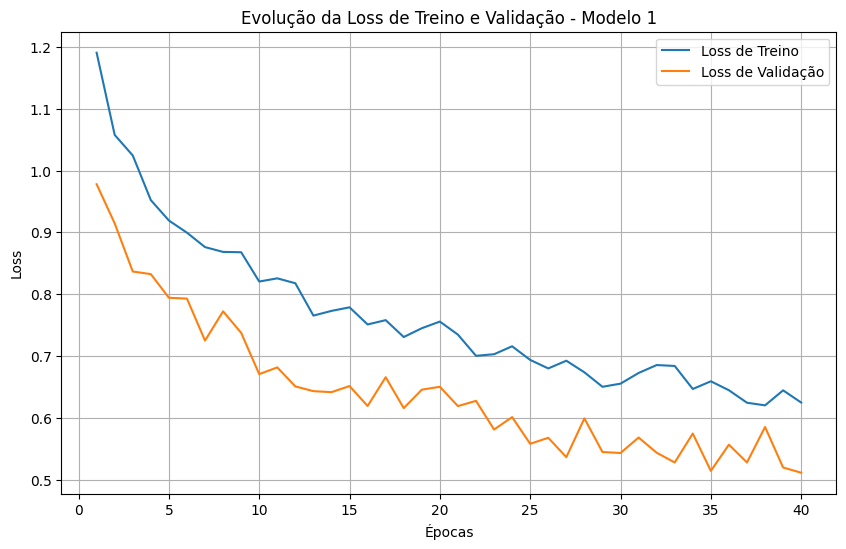

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Loss de Treino')
plt.plot(range(1, num_epochs + 1), val_losses, label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Evolução da Loss de Treino e Validação - Modelo 1')
plt.legend()
plt.grid(True)
plt.show()

Avaliação do modelo

In [19]:
from sklearn.metrics import confusion_matrix
with torch.no_grad():
    CM = 0
    correct, total = 0, 0
    for images, labels, img_id in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        CM+=confusion_matrix(labels.cpu(), predicted.cpu(),labels=[0,1,2,3])

    print(f"Accuracy: {100 * correct / total} %") 

Accuracy: 75.26881720430107 %


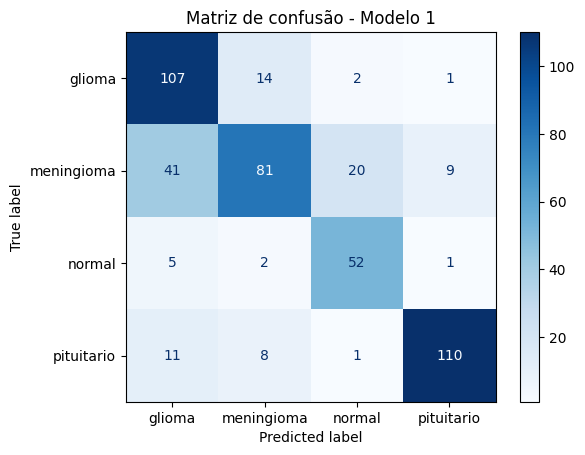

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = ['glioma', 'meningioma', 'normal', 'pituitario'])

cm_display.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusão - Modelo 1')
plt.show()

### Segundo modelo

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)  # Ajustado para corresponder ao tamanho da saída da última camada convolucional
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.dropout(self.fc1(out))
        out = self.dropout(self.fc2(out))
        out = self.fc3(out)
        return out

In [22]:
model2 = ConvNet()
model2

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Batc

In [23]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
writer = SummaryWriter()

In [24]:
def eval_loss2(data_loader):    
    with torch.no_grad():
        loss, cnt = 0, 0
        for images, labels, img_id in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model2(images)
            loss += loss_func(outputs, labels).item()
            cnt += 1
    return loss/cnt  

In [25]:
num_epochs = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model2.to(device)

best_loss = np.inf

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    loss_epoch, cnt = 0, 0
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):  
        
        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Fazendo a forward pass
        outputs2 = model2(batch_images)
        loss = loss_func(outputs2, batch_labels)
        loss_epoch += loss.item()
        
        # Fazendo a otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        cnt += 1
        
        
    loss_epoch = loss_epoch / cnt
    loss_val_epoch = eval_loss2(val_dataloader)
    
    
    train_losses.append(loss_epoch)
    val_losses.append(loss_val_epoch)


    writer.add_scalar("LossTrain", loss_epoch, epoch)
    writer.add_scalar("LossVal", loss_val_epoch, epoch)
    
    temp = {
        "Train": loss_epoch,
        "Val": loss_val_epoch
    }
    writer.add_scalars("Loss", temp, epoch)
    
        
    # Salvando o checkpoint da última época
    checkpoint = {
            'epoch': epoch,
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'loss_val': loss_epoch
    }        
    torch.save(checkpoint, "last_checkpoint.pth")

    # Salvando a mellhor execução    
    if loss < best_loss:        
        best_loss = loss
        torch.save(checkpoint, "best_checkpoint.pth")
        
    
    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {loss_epoch:.4f} | Loss Val: {loss_val_epoch:.4f}")

- Epoch [1/40] | Loss: 1.6689 | Loss Val: 1.5181
- Epoch [2/40] | Loss: 1.2799 | Loss Val: 1.1508
- Epoch [3/40] | Loss: 1.1274 | Loss Val: 0.9584
- Epoch [4/40] | Loss: 1.0181 | Loss Val: 0.9863
- Epoch [5/40] | Loss: 0.9270 | Loss Val: 0.8184
- Epoch [6/40] | Loss: 0.8256 | Loss Val: 0.6613
- Epoch [7/40] | Loss: 0.8076 | Loss Val: 0.7092
- Epoch [8/40] | Loss: 0.7892 | Loss Val: 0.6816
- Epoch [9/40] | Loss: 0.6775 | Loss Val: 0.5859
- Epoch [10/40] | Loss: 0.6459 | Loss Val: 0.5563
- Epoch [11/40] | Loss: 0.6304 | Loss Val: 0.5287
- Epoch [12/40] | Loss: 0.6401 | Loss Val: 0.6327
- Epoch [13/40] | Loss: 0.6086 | Loss Val: 0.4883
- Epoch [14/40] | Loss: 0.5556 | Loss Val: 0.4670
- Epoch [15/40] | Loss: 0.5533 | Loss Val: 0.6162
- Epoch [16/40] | Loss: 0.5409 | Loss Val: 0.5452
- Epoch [17/40] | Loss: 0.4923 | Loss Val: 0.4174
- Epoch [18/40] | Loss: 0.5010 | Loss Val: 0.4844
- Epoch [19/40] | Loss: 0.4730 | Loss Val: 0.4961
- Epoch [20/40] | Loss: 0.4605 | Loss Val: 0.4094
- Epoch [

In [26]:
eval_loss2(test_dataloader)

0.3525540642440319

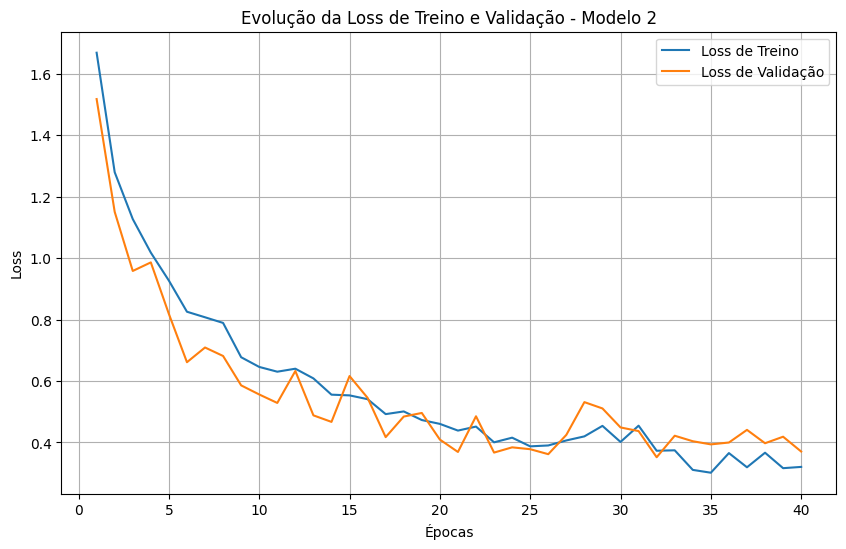

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Loss de Treino')
plt.plot(range(1, num_epochs + 1), val_losses, label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Evolução da Loss de Treino e Validação - Modelo 2')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix
with torch.no_grad():
    CM=0
    correct, total = 0, 0
    for images, labels, img_id in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        CM+=confusion_matrix(labels.cpu(), predicted.cpu(),labels=[0,1,2,3])
    print(f"Accuracy: {100 * correct / total} %") 

Accuracy: 90.96774193548387 %


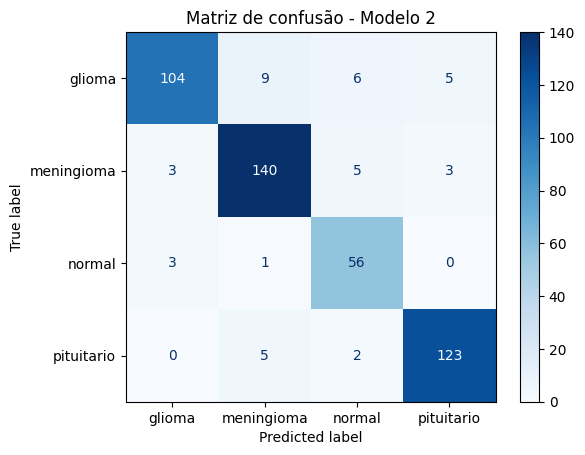

In [29]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = ['glioma', 'meningioma', 'normal', 'pituitario'])

cm_display.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusão - Modelo 2')
plt.show()